---

In [1]:
from pathlib import Path

path = Path().absolute()

In [2]:
cd ../

c:\Users\c10nGp4\OneDrive\Documents\GitHub\imbalance-multi-classification


In [3]:
import pickle
import time

from sklearn.pipeline import Pipeline

---

### Load Data
---

In [4]:
import pandas as pd

# Load training set
training_set_df = pd.read_csv(path / "assets/datasets/training-set-1.csv", delimiter=";")

# Get X and y from dataset
X_train = list(training_set_df["texts"])
y_train = list(training_set_df["targets"])

### Data Preparation
---

#### Text Preprocessing

In [5]:
from pipeline.text_cleaning import TextCleaning
from pipeline.tokenize_mwt_pos_lemma import TokenizeMWTPOSLemma

text_preprocessing_pipeline: Pipeline = Pipeline([
    ("text_cleaning", TextCleaning()),
    ("tokenize_mwt_pos_lemma", TokenizeMWTPOSLemma())
])

X_train = text_preprocessing_pipeline.transform(X_train)

2023-06-12 10:41:10 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-06-12 10:41:10 INFO: DOWNLOAD STANZA MODEL
2023-06-12 10:41:10 INFO: LOAD STANZA PIPELINE: tokenize,mwt,pos,lemma


2023-06-12 10:41:10 INFO: Loading these models for language: id (Indonesian):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |

2023-06-12 10:41:10 INFO: Using device: cuda
2023-06-12 10:41:10 INFO: Loading: tokenize
2023-06-12 10:41:13 INFO: Loading: mwt
2023-06-12 10:41:13 INFO: Loading: pos
2023-06-12 10:41:13 INFO: Loading: lemma
2023-06-12 10:41:13 INFO: Done loading processors!


2023-06-12 10:41:13 INFO: TEXT CLEANING
2023-06-12 10:41:14 INFO: TOKENIZE, MWT, POS, LEMMA


#### Feature Selection

In [6]:
from pipeline.data.stopwords import STOPWORDS
from pipeline.pos_filter import POSFilter
from pipeline.stopword_removal import StopWordRemoval
from pipeline.document_transformer import DocumentTransformer

pos_filter_hyperparameters = {
    "pos": ("ADJ","ADV","NOUN","PART","VERB")
}

document_transformer_hyperparameters = {
    "feat_attrs": ["text"]
}

feature_selection_pipeline: Pipeline = Pipeline([
    ("pos_filter", POSFilter(**pos_filter_hyperparameters, verbose=0)),
    ("document_transformer", DocumentTransformer(**document_transformer_hyperparameters, verbose=0))
])

X_train = feature_selection_pipeline.transform(X_train)

### Hyper-parameters tuning
---

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

def fun(arg):
    return arg

tfidfvectorizer_hyperparameters = {
    "encoding": "ascii",
    "decode_error": "ignore",
    "strip_accents": "ascii",
    "preprocessor": fun,
    "tokenizer": fun,
    "analyzer": "word",
    "token_pattern": None,
    "max_df": 1.0
}

linearsvc_hyperparameters = {
    "loss": "squared_hinge",
    "dual": False,
    "multi_class": "ovr",
    "max_iter": 1000000,
    "random_state": 42,
    "tol": 0.0001,
    "fit_intercept": True,
}

classification_pipeline: Pipeline = Pipeline([
    ("tfidfvectorizer", TfidfVectorizer(**tfidfvectorizer_hyperparameters)),
    ("linearsvc", LinearSVC(**linearsvc_hyperparameters))
])

In [8]:
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import make_scorer, accuracy_score, matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("default", category=ConvergenceWarning)

param_distributions = {
    "tfidfvectorizer__ngram_range": ((1, 1), (1, 2), (1, 3)),
    "tfidfvectorizer__min_df": (1, 3, 5),
    "tfidfvectorizer__norm": ("l1", "l2"),
    "tfidfvectorizer__sublinear_tf": (True, False),
    "linearsvc__penalty": ("l1", "l2"),
    "linearsvc__C": (0.1, 1),
    "linearsvc__intercept_scaling": (0.1, 1.0, 10, 100),
    "linearsvc__class_weight": (None, "balanced"),
}

n_iter = 200
n_splits = 5
train_size = 0.8
n_jobs = 1
verbose = 2

randomized_search = RandomizedSearchCV(
    estimator=classification_pipeline,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring=make_scorer(matthews_corrcoef),
    n_jobs=n_jobs,
    cv=StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, random_state=42),
    verbose=verbose,
    random_state=42
)

t0 = time.time()
randomized_search.fit(X_train, y_train)
estimation = time.time() - t0

cv_results_df = pd.DataFrame(randomized_search.cv_results_)
cv_results_df = cv_results_df.rename(lambda col_name: col_name.split("__")[-1] if "param_" in col_name else col_name, axis="columns")

col_names = [
    "ngram_range","min_df","norm","sublinear_tf",
    "penalty","C","intercept_scaling","class_weight",
    "split0_test_score","split1_test_score","split2_test_score","split3_test_score","split4_test_score","mean_test_score",
    "mean_fit_time",
    "rank_test_score"
]

cv_results_df = cv_results_df.reindex(columns=col_names)
cv_results_df = cv_results_df.fillna("None")
cv_results_df.to_csv(path / "assets/experiments/experiment_5_cv_results.csv", sep=";", index=False)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END linearsvc__C=0.1, linearsvc__class_weight=None, linearsvc__intercept_scaling=10, linearsvc__penalty=l1, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2), tfidfvectorizer__norm=l2, tfidfvectorizer__sublinear_tf=True; total time=   0.3s
[CV] END linearsvc__C=0.1, linearsvc__class_weight=None, linearsvc__intercept_scaling=10, linearsvc__penalty=l1, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2), tfidfvectorizer__norm=l2, tfidfvectorizer__sublinear_tf=True; total time=   0.3s
[CV] END linearsvc__C=0.1, linearsvc__class_weight=None, linearsvc__intercept_scaling=10, linearsvc__penalty=l1, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram_range=(1, 2), tfidfvectorizer__norm=l2, tfidfvectorizer__sublinear_tf=True; total time=   0.3s
[CV] END linearsvc__C=0.1, linearsvc__class_weight=None, linearsvc__intercept_scaling=10, linearsvc__penalty=l1, tfidfvectorizer__min_df=5, tfidfvectorizer__ngram

In [9]:
cv_results_df

,ngram_range,min_df,norm,sublinear_tf,penalty,C,intercept_scaling,class_weight,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,mean_fit_time,rank_test_score
0,"(1, 2)",5,l2,True,l1,0.1,10.0,None,0.669054,0.667345,0.672715,0.687079,0.659879,0.671214,0.376539,89
1,"(1, 3)",5,l2,True,l1,1.0,10.0,None,0.717712,0.715095,0.713094,0.718204,0.715318,0.715885,2.379599,21
2,"(1, 3)",1,l1,True,l1,1.0,0.1,None,0.678046,0.685729,0.677276,0.698157,0.676281,0.683098,1.058217,74
3,"(1, 1)",5,l1,True,l1,0.1,100.0,None,0.524474,0.528511,0.531226,0.538053,0.532944,0.531042,0.137623,168
4,"(1, 2)",5,l2,False,l2,1.0,1.0,None,0.687057,0.692929,0.678064,0.691362,0.692837,0.688450,0.477181,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,"(1, 2)",5,l2,True,l2,0.1,10.0,None,0.687940,0.688995,0.692581,0.691575,0.676340,0.687487,0.444036,66
196,"(1, 1)",1,l2,False,l1,0.1,10.0,balanced,0.643615,0.646112,0.652700,0.648153,0.643642,0.646844,0.281976,132
197,"(1, 3)",3,l2,True,l2,1.0,10.0,balanced,0.695164,0.719819,0.702089,0.701984,0.713393,0.706490,0.738279,39
198,"(1, 3)",3,l1,True,l1,1.0,100.0,balanced,0.715939,0.726729,0.710454,0.725250,0.716059,0.718886,0.862375,16


In [10]:
from datetime import timedelta

print(f'Fitted {randomized_search.n_splits_} folds of {len(cv_results_df)} candidates, finished in {str(timedelta(seconds=estimation))}.')
print(f"Best score: {randomized_search.best_score_}")
print("Best hyper-parameters:")
randomized_search.best_params_

Fitted 5 folds of 200 candidates, finished in 0:29:03.351811.
Best score: 0.7283546639750673
Best hyper-parameters:


{'tfidfvectorizer__sublinear_tf': True,
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__min_df': 1,
 'linearsvc__penalty': 'l1',
 'linearsvc__intercept_scaling': 100,
 'linearsvc__class_weight': 'balanced',
 'linearsvc__C': 1}

### Load Data
---

In [13]:
# Load dataset
testing_set_df = pd.read_csv(path / "assets/datasets/testing-set-1.csv", delimiter=";")

X_test = list(testing_set_df["texts"])
y_test = list(testing_set_df["targets"])

### Data Preparation
---

In [14]:
from pipeline.text_cleaning import TextCleaning
from pipeline.tokenize_mwt_pos_lemma import TokenizeMWTPOSLemma

# Text Preprocessing
X_test = text_preprocessing_pipeline.transform(X_test)
X_test = feature_selection_pipeline.transform(X_test)

2023-06-12 11:21:12 INFO: TEXT CLEANING
2023-06-12 11:21:13 INFO: TOKENIZE, MWT, POS, LEMMA


In [17]:
y_pred = randomized_search.best_estimator_.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score, matthews_corrcoef

print("Accuracy:", accuracy_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))

Accuracy: 0.7977972324202203
MCC: 0.7372213177029623


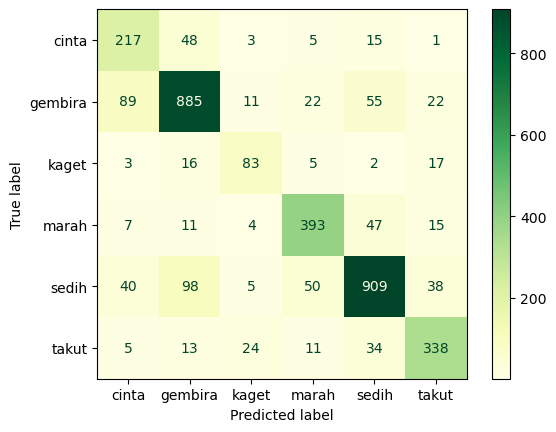

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

normalize = None
# normalize="true"

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize=normalize, cmap="YlGn")